In [1]:
import os
import wfdb
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler

def load_mitbih_dataset(path):
    # Define a list of annotation symbols that represent different types of heartbeats
    annots_list = ['N', 'L', 'R', 'e', 'j', 'S', 'A', 'a', 'J', 'V', 'E', 'F', '/', 'f', 'Q']

    # Prepare empty lists to store signal segments and corresponding labels
    X = []
    y = []

    # Create a dictionary to map each annotation symbol to a unique integer
    annot_to_int = {annot: i for i, annot in enumerate(annots_list)}

    # Read the list of ECG record filenames from the 'RECORDS' file in the dataset directory
    record_list = []
    with open(os.path.join(path, 'RECORDS'), 'r') as file:
        record_list = [line.strip() for line in file]

    # Create an instance of the MinMaxScaler to scale each segment to the range [0, 1]
    scaler = MinMaxScaler(feature_range=(0, 1))

    # Iterate over each record file in the dataset
    for record_name in record_list:
        # Load the ECG record and its annotations using the wfdb library
        record = wfdb.rdrecord(os.path.join(path, record_name))
        annotation = wfdb.rdann(os.path.join(path, record_name), 'atr')

        # Extract the first channel of the ECG signal (assuming it's a single-channel ECG)
        signal = record.p_signal[:, 0]
        # Get the symbols and sample locations for each annotated beat
        beat_annotations = annotation.symbol
        beat_locations = annotation.sample

        # Process each annotated beat in the current record
        for sym, loc in zip(beat_annotations, beat_locations):
            # Check if the annotation symbol is one of the types we're interested in
            if sym in annots_list:
                # Convert the annotation symbol to its corresponding integer label
                label = annot_to_int[sym]
                
                # Define the window size around the beat location to extract the segment
                win_size = 625  # This results in segments of 1250 samples centered on the beat
                # Ensure that the window does not extend beyond the signal boundaries
                if loc - win_size >= 0 and loc + win_size <= len(signal):
                    # Extract the segment of the signal centered around the beat
                    segment = signal[loc - win_size: loc + win_size]
                    # Normalize the segment to the range [0, 1]
                    segment = scaler.fit_transform(segment.reshape(-1, 1)).flatten()
                    # Add the normalized segment to the list of segments
                    X.append(segment)
                    # Add the label to the list of labels
                    y.append(label)

    # Convert the lists of segments and labels to numpy arrays for use in machine learning models
    X = np.array(X)
    # Convert the integer labels to one-hot encoded format
    y = to_categorical(y, num_classes=len(annots_list))

    return X, y


2024-05-08 21:24:27.560285: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-08 21:24:27.590008: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 21:24:27.590030: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 21:24:27.590676: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-08 21:24:27.595408: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Normalization: Before reshaping data, each 1D segment is normalized so that pixel values are between 0 and 1. This matches the typical preprocessing for CNNs that deal with image data.
# Padding and Trimming: Depending on length of ECG segment and desired target_shape, segment may either need padding (with zeros) to increase its length, or trimming to reduce it. This ensures that each reshaped segment fits perfectly into specified 2D shape.
# 2D Reshape and Channel Replication: Each segment is reshaped into a 2D array. Since the VGG16 model is designed for RGB images, the single-channel 2D array is replicated across three channels to mimic an RGB image. This step is crucial because it adapts the 1D signal data to the input requirements of a model designed for 3D color images.


import numpy as np
from sklearn.preprocessing import MinMaxScaler

def reshape_ecg_to_2d(X, target_shape=(32, 32)):
    """
    Reshape 1D ECG data into 2D format with three channels to fit into a VGG16 model.

    Args:
    X (array): 1D numpy array of ECG data.
    target_shape (tuple): The target dimensions to which each ECG segment will be reshaped.

    Returns:
    numpy.array: A 4D array where each ECG segment is reshaped into 2D and replicated across three channels.
    """
    # Initialize the scaler to normalize data
    scaler = MinMaxScaler(feature_range=(0, 1))

    # Prepare a list to hold the reshaped segments
    X_reshaped = []
    
    # Process each segment in the dataset
    for segment in X:
        # Normalize the segment
        segment_normalized = scaler.fit_transform(segment.reshape(-1, 1)).flatten()
        
        # Calculate the padding required to reach the target size, if necessary
        padding = target_shape[0] * target_shape[1] - len(segment_normalized)
        
        if padding > 0:
            # If the segment is too short, pad it with zeros at the end
            segment_normalized = np.pad(segment_normalized, (0, padding), 'constant')
        elif padding < 0:
            # If the segment is too long, trim the excess
            segment_normalized = segment_normalized[:padding]
        
        # Reshape the normalized segment into 2D format
        segment_2d = segment_normalized.reshape(target_shape)
        
        # Stack the 2D image across three channels since VGG16 expects three-channel input images
        segment_3ch = np.stack([segment_2d] * 3, axis=-1)
        
        # Append the reshaped segment to the list
        X_reshaped.append(segment_3ch)

    return np.array(X_reshaped)

# Load your data
X, y = load_mitbih_dataset("/home/researchgroup/mahjabeen_workspace/research/CLINet-ECG-Classification-2024/data/mit-bih/mitbih_database/")

# Reshape your 1D ECG data into 2D
X_2d = reshape_ecg_to_2d(X)


In [3]:
import numpy as np
from sklearn.model_selection import train_test_split

def load_and_reshape_data(path):
    # Load preprocessed data
    X, y = load_mitbih_dataset(path)

    # Reshape data for 2D CNN input if not already reshaped
    # Assuming each sample is 1250 long, reshape to 25x50 2D array
    X_reshaped = X.reshape(-1, 25, 50, 1)  # Change dimensions as needed for your network architecture

    return X_reshaped, y

# Specify the path to your dataset
data_path = "/home/researchgroup/mahjabeen_workspace/research/CLINet-ECG-Classification-2024/data/mit-bih/mitbih_database/"

# Load and reshape the dataset
X, y = load_and_reshape_data(data_path)

# # Step 1: Perform the split once
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# # Step 2: Save the split data to disk for later use
# np.save('./X_train.npy', X_train)
# np.save('./X_test.npy', X_test)
# np.save('./y_train.npy', y_train)
# np.save('./y_test.npy', y_test)


In [4]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import Precision, Recall

def create_vgg16_model(num_classes, input_shape=(25, 50, 1), optimizer_type='adam', learning_rate=0.001):
    # Input layer with specified shape, suitable for 2D data processing
    inputs = Input(shape=input_shape)
    
    # First block of two convolutional layers with 32 filters, followed by max-pooling to reduce spatial dimensions
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Second block of two convolutional layers with 64 filters
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Third block of three convolutional layers with 128 filters
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Flatten the output of the last pooling layer to prepare it for the dense layer
    x = Flatten()(x)

    # Dense layer with 512 units and ReLU activation for learning the final features
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)  # Dropout layer to prevent overfitting

    # Output layer with softmax activation to classify the data into one of the possible classes
    outputs = Dense(num_classes, activation='softmax')(x)

    # Choose the optimizer: Adam for adaptive learning rate or SGD with momentum
    if optimizer_type == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = SGD(learning_rate=learning_rate, momentum=0.9)

    # Compile the model with categorical cross-entropy loss and additional metrics (accuracy, precision, and recall)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

    return model


Training new model...


2024-05-08 21:52:32.713503: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8231 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:1a:00.0, compute capability: 8.6
2024-05-08 21:52:32.713996: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 8078 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:68:00.0, compute capability: 8.6


Epoch 1/20


2024-05-08 21:52:34.863919: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-05-08 21:52:35.804995: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fe75cb322a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-08 21:52:35.805028: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-05-08 21:52:35.805033: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-05-08 21:52:35.811357: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1715230355.895397  236850 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2733/2733 [==============================] - ETA: 0s - loss: 0.3011 - accuracy: 0.9207 - precision_1: 0.9422 - recall_1: 0.8997
Epoch 1: val_loss improved from inf to 0.12350, saving model to ./final_model_vgg16.h5
2733/2733 [==============================] - 35s 11ms/step - loss: 0.3011 - accuracy: 0.9207 - precision_1: 0.9422 - recall_1: 0.8997 - val_loss: 0.1235 - val_accuracy: 0.9669 - val_precision_1: 0.9727 - val_recall_1: 0.9607 - lr: 0.0010
Epoch 2/20
  13/2733 [..............................] - ETA: 23s - loss: 0.1479 - accuracy: 0.9688 - precision_1: 0.9781 - recall_1: 0.9663

/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2733/2733 [==============================] - ETA: 0s - loss: 0.1075 - accuracy: 0.9712 - precision_1: 0.9760 - recall_1: 0.9670
Epoch 2: val_loss improved from 0.12350 to 0.09717, saving model to ./final_model_vgg16.h5
2733/2733 [==============================] - 30s 11ms/step - loss: 0.1075 - accuracy: 0.9712 - precision_1: 0.9760 - recall_1: 0.9670 - val_loss: 0.0972 - val_accuracy: 0.9760 - val_precision_1: 0.9821 - val_recall_1: 0.9699 - lr: 0.0010
Epoch 3/20
2733/2733 [==============================] - ETA: 0s - loss: 0.0892 - accuracy: 0.9764 - precision_1: 0.9800 - recall_1: 0.9731
Epoch 3: val_loss improved from 0.09717 to 0.06964, saving model to ./final_model_vgg16.h5
2733/2733 [==============================] - 30s 11ms/step - loss: 0.0892 - accuracy: 0.9764 - precision_1: 0.9800 - recall_1: 0.9731 - val_loss: 0.0696 - val_accuracy: 0.9824 - val_precision_1: 0.9842 - val_recall_1: 0.9801 - lr: 0.0010
Epoch 4/20
2731/2733 [============================>.] - ETA: 0s - loss: 0.0

TypeError: 'History' object is not subscriptable

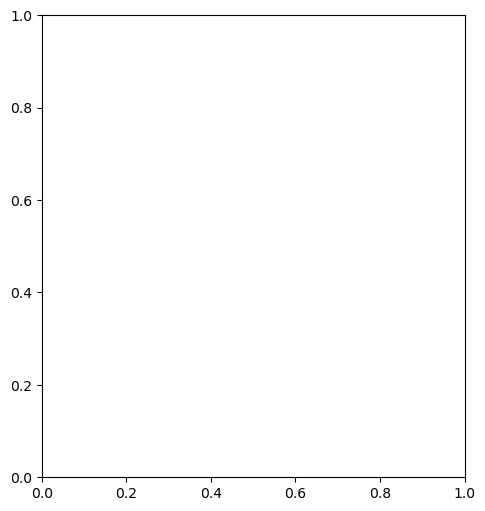

In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import json

def train_and_save_model():
    # Load pre-split data from disk, formatted as 2D arrays (reshaped during preprocessing)
    X_train = np.load('./X_train.npy')
    X_test = np.load('./X_test.npy')
    y_train = np.load('./y_train.npy')
    y_test = np.load('./y_test.npy')
    
    # Define paths for the model and training history files
    model_path = './final_model_vgg16.h5'
    history_path = './model_history_vgg16.json'

    # Check if the model and history files already exist to avoid retraining
    if os.path.exists(model_path) and os.path.exists(history_path):
        print("Model and training history already exist. Loading...")
        model = keras.models.load_model(model_path)  # Load the pre-trained model
        with open(history_path, 'r') as f:
            history = json.load(f)  # Load the training history
    else:
        print("Training new model...")
        # Initialize and compile the VGG16-inspired model
        model = create_vgg16_model(num_classes=y_train.shape[1], input_shape=(25, 50, 1))
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

        # Set up callbacks for saving the best model, early stopping, and reducing learning rate on plateau
        callbacks = [
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1),
            keras.callbacks.ModelCheckpoint(model_path, save_best_only=True, verbose=1),
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
        ]

        # Train the model
        history = model.fit(X_train, y_train, epochs=20, batch_size=32,  # Adjusted batch size to fit memory constraints
                            validation_data=(X_test, y_test), callbacks=callbacks)
        print("Training completed. Model saved.")
        # Convert the training history to native Python types
        history_dict = {k: [float(val) for val in v] for k, v in history.history.items()}
        # Save the training history to a JSON file
        with open(history_path, 'w') as f:
            json.dump(history_dict, f)
            print("Training history saved.")

    return model, history

def plot_learning_curves(history):
    # Plot the learning curves for accuracy and loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')
    plt.show()

if __name__ == "__main__":
    model, history = train_and_save_model()
    plot_learning_curves(history)


Model loaded successfully.
684/684 [==============================] - 3s 5ms/step - loss: 0.0568 - accuracy: 0.9884 - precision_1: 0.9888 - recall_1: 0.9879
Test Loss, Test Accuracy, and other metrics: [0.056825969368219376, 0.9883795380592346, 0.9888268113136292, 0.9879220128059387]
684/684 [==============================] - 3s 4ms/step


/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo


Classification Report:
              precision    recall  f1-score   support

           N       0.99      1.00      0.99     14995
           L       0.99      0.99      0.99      1594
           R       0.99      1.00      0.99      1500
           e       0.00      0.00      0.00         2
           j       0.85      0.84      0.85        49
           S       0.00      0.00      0.00         1
           A       0.96      0.91      0.93       467
           a       0.74      0.52      0.61        27
           J       0.50      0.25      0.33        12
           V       0.97      0.97      0.97      1444
           E       0.89      1.00      0.94        16
           F       0.91      0.77      0.84       145
           /       0.99      1.00      0.99      1408
           f       0.93      0.92      0.93       182
           Q       0.00      0.00      0.00        16

    accuracy                           0.99     21858
   macro avg       0.71      0.68      0.69     21858
we

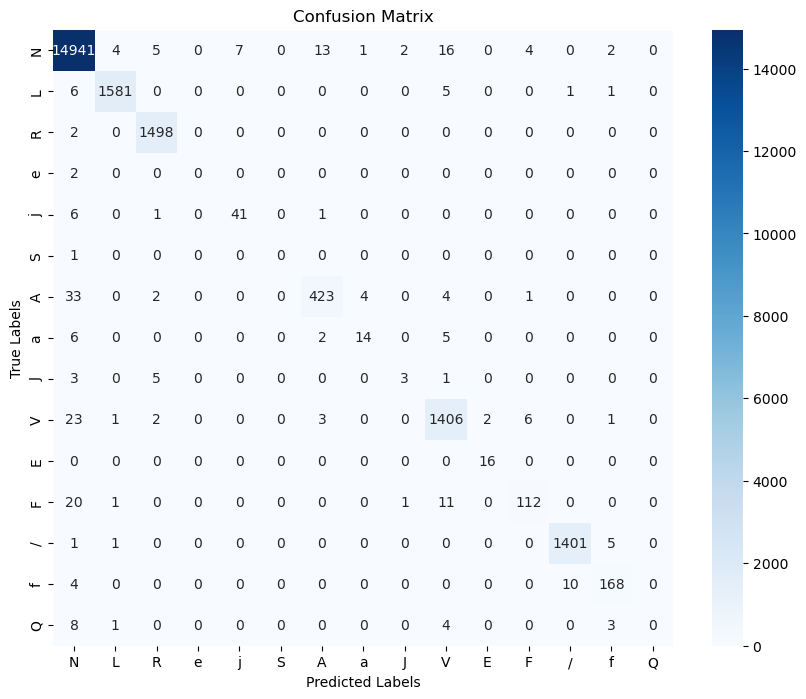

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Define the class labels based on your annots_list
class_labels = ['N', 'L', 'R', 'e', 'j', 'S', 'A', 'a', 'J', 'V', 'E', 'F', '/', 'f', 'Q']

def load_and_evaluate(threshold=0.5):
    # Load the test data
    X_test = np.load('./X_test.npy')
    y_test = np.load('./y_test.npy')
    # Reshape for the CNN that expects 2D input
    X_test = X_test.reshape((X_test.shape[0], 25, 50, 1))  # Adjust the dimensions to match the 2D format expected by the model

    # Load the trained VGG16-like model
    model_path = './final_model_vgg16.h5'
    if not os.path.exists(model_path):
        print("Model file not found!")
        return
    model = keras.models.load_model(model_path)
    print("Model loaded successfully.")

    # Evaluate the model on the test data
    results = model.evaluate(X_test, y_test, verbose=1)
    print(f'Test Loss, Test Accuracy, and other metrics: {results}')

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Generate a classification report with actual class labels
    report_dict = classification_report(y_true_classes, y_pred_classes, target_names=class_labels, output_dict=True)
    print("\nClassification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=class_labels))

    # Identify underperforming classes based on the f1-score
    underperforming_classes = [cls for cls, metrics in report_dict.items() if cls in class_labels and metrics['f1-score'] < threshold]
    print(f"Underperforming classes: {underperforming_classes}")

    # Save the underperforming classes for focused training later
    with open('underperforming_classes.json', 'w') as f:
        json.dump(underperforming_classes, f)
        print("Underperforming classes saved.")

    # Confusion Matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    return y_pred_classes

if __name__ == "__main__":
    predicted_classes = load_and_evaluate()
